In [1]:
from warnings import filterwarnings

filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from crypto_momentum_portfolios.utility.data_loader import CryptoDataLoaderQIL
from crypto_momentum_portfolios.utility.types import (
    DataFrequency,
    Fields,
    RebalanceFrequency,
    Side,
    RankingMode,
    AllocationMethod,
    RankingMethod,
    AllocationMode,
    Benchmark,
)
from crypto_momentum_portfolios.portfolio_management.benchmarks import (
    BenchmarkDataFrameBuilder,
)
from crypto_momentum_portfolios.portfolio_management.backtester import (
    PortfolioBacktester,
)

dl = CryptoDataLoaderQIL()  # CryptoDataLoader()
dl.assets

Loading BokehJS ...

Fetching symbols...: 100%|██████████| 21/21 [00:00<00:00, 97.53it/s]


['BTC-USDT',
 'SOL-USDT',
 'DASH-USDT',
 'ETC-USDT',
 'VET-USDT',
 'BCH-USDT',
 'EOS-USDT',
 'TRX-USDT',
 'MATIC-USDT',
 'LINK-USDT',
 'KDA-USDT',
 'ETH-USDT',
 'AVAX-USDT',
 'LTC-USDT',
 'DOGE-USDT',
 'XTZ-USDT',
 'BNB-USDT',
 'ATOM-USDT',
 'XLM-USDT',
 'ADA-USDT',
 'XRP-USDT']

In [2]:
MOMENTUM_LOOKBACK = 30
universe = (
    dl.get_crypto(
        "all",
        data_frequency=DataFrequency.DAILY,
        fields=[
            Fields.PRICE,
            Fields.MARKET_CAP,
            Fields.MOMENTUM,
            Fields.EMA_MOMENTUM,
            Fields.TS_MOMENTUM,
            Fields.VOLATILITY_NEUTRALIZED_MOMENTUM,
            Fields.RETURNS,
            Fields.VOLATILITY,
            Fields.VOLUME,
        ],
        flatten_fields_with_crypto=False,
        momentum_lookback=MOMENTUM_LOOKBACK,
    )
    .dropna()
    .loc["2021-11-28":]  # "2021-10-28"
)
universe.head()

price                                                          \
           BTC-USDT SOL-USDT DASH-USDT ETC-USDT  VET-USDT BCH-USDT EOS-USDT   
Date                                                                          
2021-11-28  57275.5  200.770    178.47  47.4672  0.116423   568.80   3.9674   
2021-11-29  57777.4  204.070    182.01  48.1875  0.121283   574.83   4.0034   
2021-11-30  56928.1  208.286    179.95  48.2260  0.119140   569.70   4.0046   
2021-12-01  57187.5  229.740    178.17  47.8143  0.118240   570.69   3.9915   
2021-12-02  56484.6  233.679    176.11  47.0044  0.115829   561.47   3.9642   

                                           ...        volume                \
            TRX-USDT MATIC-USDT LINK-USDT  ...      ETH-USDT     AVAX-USDT   
Date                                       ...                               
2021-11-28  0.095186     1.6526   24.7679  ...  3.233202e+08  6.602496e+07   
2021-11-29  0.096539     1.8160   24.9948  ...  2.890552e+08  6.143154e+07   
2021-11-30  0.096508     1.7822   25.3025  ...  5.012545e+08  7.555661e+07   
2021-12-01  0.096862     2.0064   25.3274  ...  3.540249e+08  5.896180e+07   
2021-12-02  0.097486     2.1219   24.5515  ...  3.665087e+08  4.944683e+07   

                                                                    \
                LTC-USDT     DOGE-USDT      XTZ-USDT      BNB-USDT   
Date                                                                 
2021-11-28  3.164576e+07  1.532284e+07  2.730971e+06  4.840454e+07   
2021-11-29  2.372944e+07  2.439830e+07  1.153953e+07  5.034533e+07   
2021-11-30  3.569569e+07  3.369813e+07  2.437584e+07  4.914960e+07   
2021-12-01  2.511659e+07  1.829530e+07  8.126870e+06  4.456517e+07   
2021-12-02  2.276300e+07  2.544782e+07  4.575999e+06  3.934883e+07   

                                                                    
               ATOM-USDT      XLM-USDT      ADA-USDT      XRP-USDT  
Date                                                                
2021-11-28  1.631741e+07  1.085601e+07  5.131104e+07  7.165532e+07  
2021-11-29  9.970759e+06  9.490191e+06  3.363372e+07  6.614817e+07  
2021-11-30  1.922474e+07  1.485177e+07  4.287083e+07  8.494273e+07  
2021-12-01  1.255694e+07  1.150287e+07  3.519442e+07  5.752341e+07  
2021-12-02  1.460614e+07  1.362993e+07  1.030530e+08  5.429675e+07  

[5 rows x 189 columns]

Weight drift :

$$w_i^k=\frac{w_{i-1}^k\times (1+r_i^k)}{\sum_{j=1}^n w_{i-1}^j\times(1+r_i^j)}$$

For asset $k$ at time $i$ given $n$ asset in the portfolio.


# Building a benchmark


## Capitalization weighted index


In [9]:
benchmarks = (
    BenchmarkDataFrameBuilder(universe)
    .build_equally_weighted_benchmark(
        rebalance_frequency=RebalanceFrequency.MONTHLY, side=Side.LONG, verbose=False
    )
    .build_capitalization_weighted_benchmark(
        capitalization_field=Fields.MARKET_CAP,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        verbose=False,
    )
    .build_bitcoin_benchmark()
    .collect_benchmark_returns()
)
benchmarks

,equal_weighted_benchmark,capi_weighted_benchmark,bitcoin_benchmark
Date,,,
2021-11-28,-0.003276,0.013729,0.046803
2021-11-29,0.032969,0.023788,0.008763
2021-11-30,-0.023637,-0.013165,-0.014700
2021-12-01,0.004637,0.002385,0.004557
2021-12-02,-0.002240,-0.011346,-0.012291
...,...,...,...
2023-12-24,0.054098,0.034923,0.000096
2023-12-25,0.021938,0.016110,-0.007389
2023-12-26,-0.037910,-0.046375,-0.026917


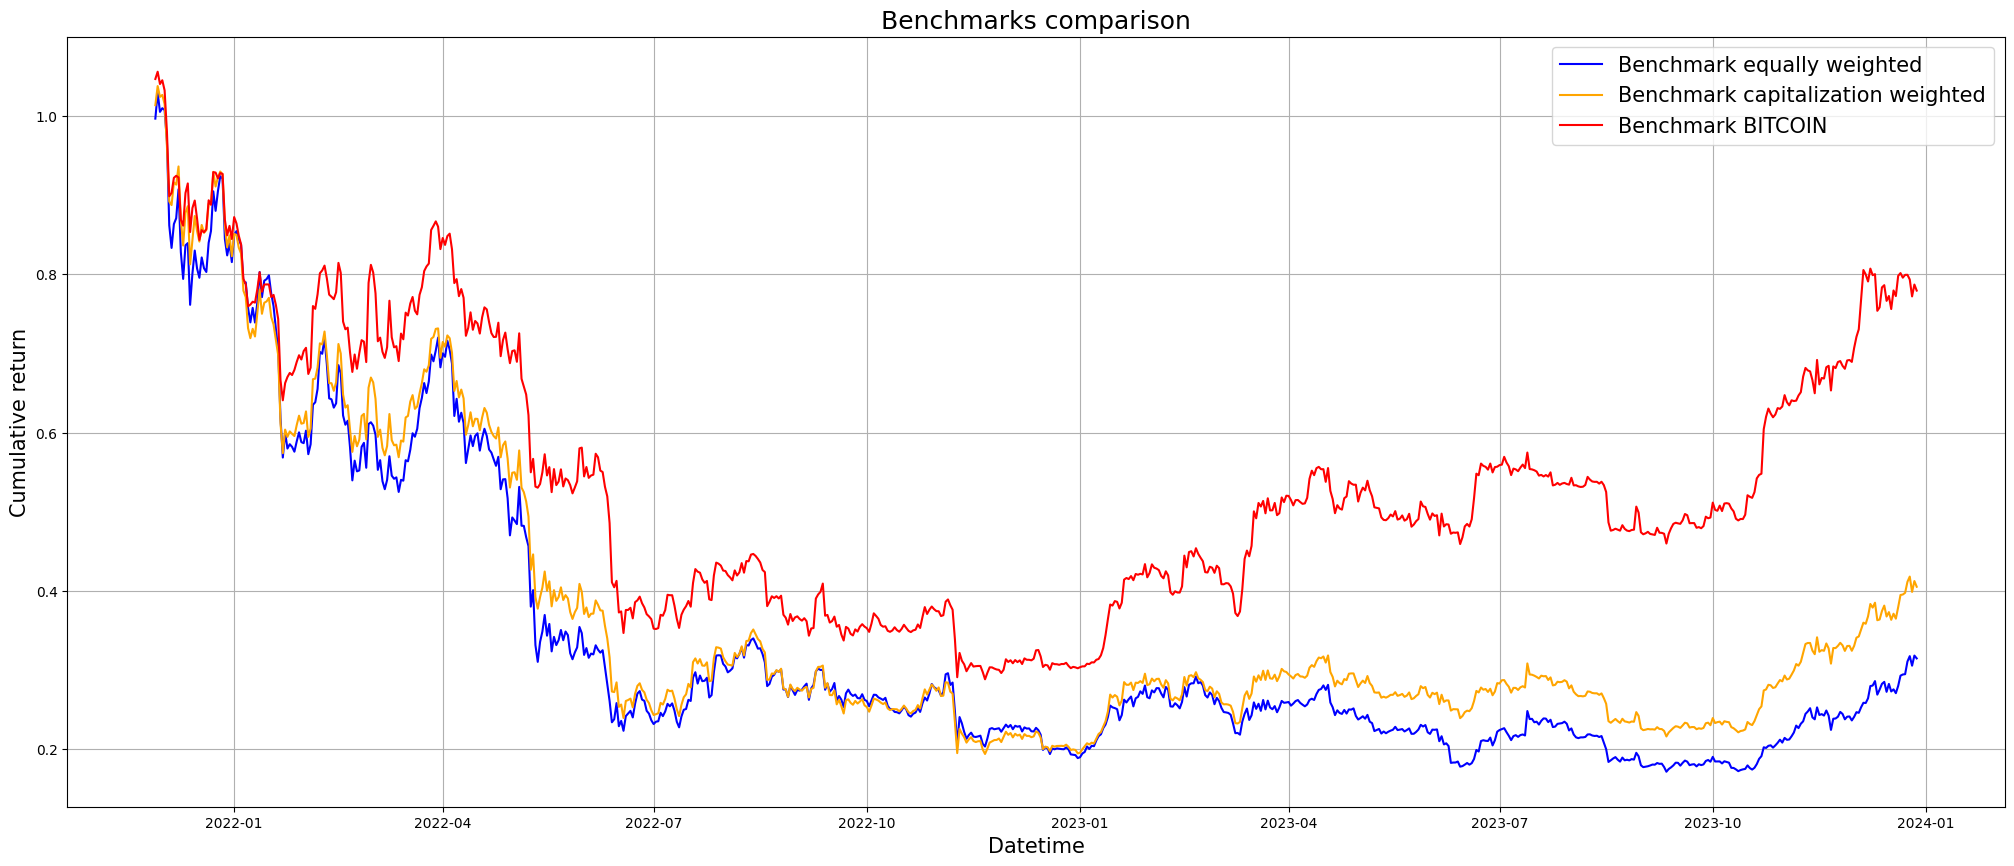

In [10]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title("Benchmarks comparison", fontsize=18)
ax.grid()
ax.plot(
    (benchmarks["equal_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark equally weighted",
    color="blue",
)
ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark capitalization weighted",
    color="orange",
)
ax.plot(
    (benchmarks["bitcoin_benchmark"] + 1).cumprod(),
    label="Benchmark BITCOIN",
    color="red",
)


ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper right", fontsize=15)
# ax.set_yscale("log")

# Backtesting strategies


## Backtesting with a benchmark and a strategy


In [11]:
ptf_backtester = PortfolioBacktester(universe=universe,)

returns_capi, _ = ptf_backtester.run_strategy(
    ranking_method=RankingMethod.MOMENTUM,
    ranking_mode=RankingMode.DESCENDING,
    select_top_k_assets=5,
    allocation_method=AllocationMethod.MOMENTUM_WEIGHTED,
    allocation_mode=AllocationMode.CLASSIC,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    benchmark=Benchmark.CAPITALIZATION_WEIGHTED,
    verbose=False,
    print_stats=True,
    plot_curve=True,
    perform_t_stats=True
)


-----------------Expected return------------------
Benchmark: -22.99% vs Strategy: 6.56%

t-stat: 3.83, p-value: 0.00
Statistically different from the bench

-----------------------CAGR-----------------------
Benchmark: -35.58% vs Strategy: -38.74%

t-stat: 7.62, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 63.41% vs Strategy: 105.52%

t-stat: 80.56, p-value: 0.00
Statistically different from the bench

---------------------Skewness---------------------
Benchmark: -0.31 vs Strategy: 0.56

t-stat: 15.75, p-value: 0.00
Statistically different from the bench

---------------------Kurtosis---------------------
Benchmark: 3.16 vs Strategy: 10.25

t-stat: 25.25, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.34% vs Strategy: -7.93%

t-stat: -50.16, p-value: 0.00
Statistically different from the bench

-----------------------CVaR----------------------

Loading BokehJS ...

Loading BokehJS ...

## Several strategies


In [ ]:
ptf_backtester = PortfolioBacktester(universe=universe)

returns_capi, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_capi.name = "capitalization_weighted"

returns_rp, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.RISK_PARITY,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_rp.name = "risk_parity"
returns_mv, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.MEAN_VARIANCE,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_mv.name = "mean_variance"
returns, weights_df = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.EQUAL_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns.name = "equal_weighted"

In [ ]:
returns_df = pd.concat([returns, returns_capi, returns_rp, returns_mv], axis=1)
returns_df

### Plot all strategies


In [ ]:
ax = (returns_df + 1).cumprod().plot(figsize=(25, 10), grid=True)

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="black",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

### Plot one strategy


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)
ax.plot(
    (returns_df["mean_variance"] + 1).cumprod(),
    label="Stretegy",
    color="blue",
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="orange",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

ax.grid()

## Weights analysis


In [ ]:
weights_df